In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyecharts
from pyecharts import options as opts
from pyecharts.globals import ThemeType

In [31]:
data = pd.read_csv("D:\浏览器下载\data3539\CreditCardUsage.csv")
data.drop(columns=['CASH_ADVANCE_TRX','PURCHASES_TRX','TENURE'],inplace = True)
data.drop_duplicates(inplace=True)

In [32]:
#重命名字段为中文名,数据集描述中的中文翻译存在错误，暂且用自己的翻译
data.columns=['持卡人ID','信用卡余额','余额变动频率','购物总额','一次付清的最大购物额','分期付款购物额','提现额','购物频率','一次付清的购物频率','分期付款购物频率','提现频率','信用卡额度','还款总额','最低还款额','全额还款比例']
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8950 entries, 0 to 8949
Data columns (total 15 columns):
持卡人ID         8950 non-null object
信用卡余额         8950 non-null float64
余额变动频率        8950 non-null float64
购物总额          8950 non-null float64
一次付清的最大购物额    8950 non-null float64
分期付款购物额       8950 non-null float64
提现额           8950 non-null float64
购物频率          8950 non-null float64
一次付清的购物频率     8950 non-null float64
分期付款购物频率      8950 non-null float64
提现频率          8950 non-null float64
信用卡额度         8949 non-null float64
还款总额          8950 non-null float64
最低还款额         8637 non-null float64
全额还款比例        8950 non-null float64
dtypes: float64(14), object(1)
memory usage: 1.1+ MB


In [33]:
#修正字段类型
for i in ['余额变动频率','购物频率','一次付清的购物频率','分期付款购物频率','提现频率']:
    data[i] = data[i].astype('int64')
data.describe().T

,count,mean,std,min,25%,50%,75%,max
信用卡余额,8950.0,1564.474828,2081.531879,0.000000,128.281915,873.385231,2054.140036,19043.13856
余额变动频率,8950.0,0.693966,0.460870,0.000000,0.000000,1.000000,1.000000,1.00000
购物总额,8950.0,1003.204834,2136.634782,0.000000,39.635000,361.280000,1110.130000,49039.57000
一次付清的最大购物额,8950.0,592.437371,1659.887917,0.000000,0.000000,38.000000,577.405000,40761.25000
分期付款购物额,8950.0,411.067645,904.338115,0.000000,0.000000,89.000000,468.637500,22500.00000
提现额,8950.0,978.871112,2097.163877,0.000000,0.000000,0.000000,1113.821139,47137.21176
购物频率,8950.0,0.243352,0.429130,0.000000,0.000000,0.000000,0.000000,1.00000
一次付清的购物频率,8950.0,0.053743,0.225522,0.000000,0.000000,0.000000,0.000000,1.00000
分期付款购物频率,8950.0,0.148715,0.355827,0.000000,0.000000,0.000000,0.000000,1.00000
提现频率,8950.0,0.003687,0.060613,0.000000,0.000000,0.000000,0.000000,1.00000


In [34]:
data.isnull().sum()

持卡人ID           0
信用卡余额           0
余额变动频率          0
购物总额            0
一次付清的最大购物额      0
分期付款购物额         0
提现额             0
购物频率            0
一次付清的购物频率       0
分期付款购物频率        0
提现频率            0
信用卡额度           1
还款总额            0
最低还款额         313
全额还款比例          0
dtype: int64

In [35]:
#简单使用knn对缺失值进行填充，如果缺失值不多直接dropna也可以，但是缺失值数量稍大时drop还是有些可惜的
def fillna(usedf,df):
    colnums=usedf.columns
    nanresults=usedf.isnull().sum()
    nancols=nanresults[nanresults.values!=0].index.values #存在缺失值的列名
    for i in nancols:
        nottreatnancols=np.setdiff1d(nancols,[i]) #存在缺失值的非处理列列名
        #划分训练集和测试集
        nottreatnotnan=usedf.drop(nottreatnancols,axis=1)
        known=nottreatnotnan.dropna() #训练集：删掉除处理列外存在缺失值的其他列，并删掉处理列存在缺失值的记录
        unknown=nottreatnotnan[nottreatnotnan[i].isnull()] #测试集：删掉除处理列外存在缺失值的其他列，在此基础上选取处理列存在缺失值的记录
        #划分已知特征和待填充特征
        xknown=known.loc[:,np.setdiff1d(known.columns,[i])]
        yknown=known.loc[:,i]
        xunknown=unknown.loc[:,np.setdiff1d(unknown.columns,[i])]
        #建模填充
        from sklearn.neighbors import KNeighborsRegressor
        knn=KNeighborsRegressor()
        knn.fit(xknown,yknown)
        yfillna=knn.predict(xunknown).reshape(-1,1) 
        df.loc[np.in1d(df.index.values,unknown.index.values),i]=yfillna #用index定位df中存在缺失值的记录
fillna(data.iloc[:,1:],data)
data.isnull().sum()

持卡人ID         0
信用卡余额         0
余额变动频率        0
购物总额          0
一次付清的最大购物额    0
分期付款购物额       0
提现额           0
购物频率          0
一次付清的购物频率     0
分期付款购物频率      0
提现频率          0
信用卡额度         0
还款总额          0
最低还款额         0
全额还款比例        0
dtype: int64

In [36]:
df=data.iloc[:,1:].copy() #数据备份

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5]), <a list of 14 Text xticklabel objects>)

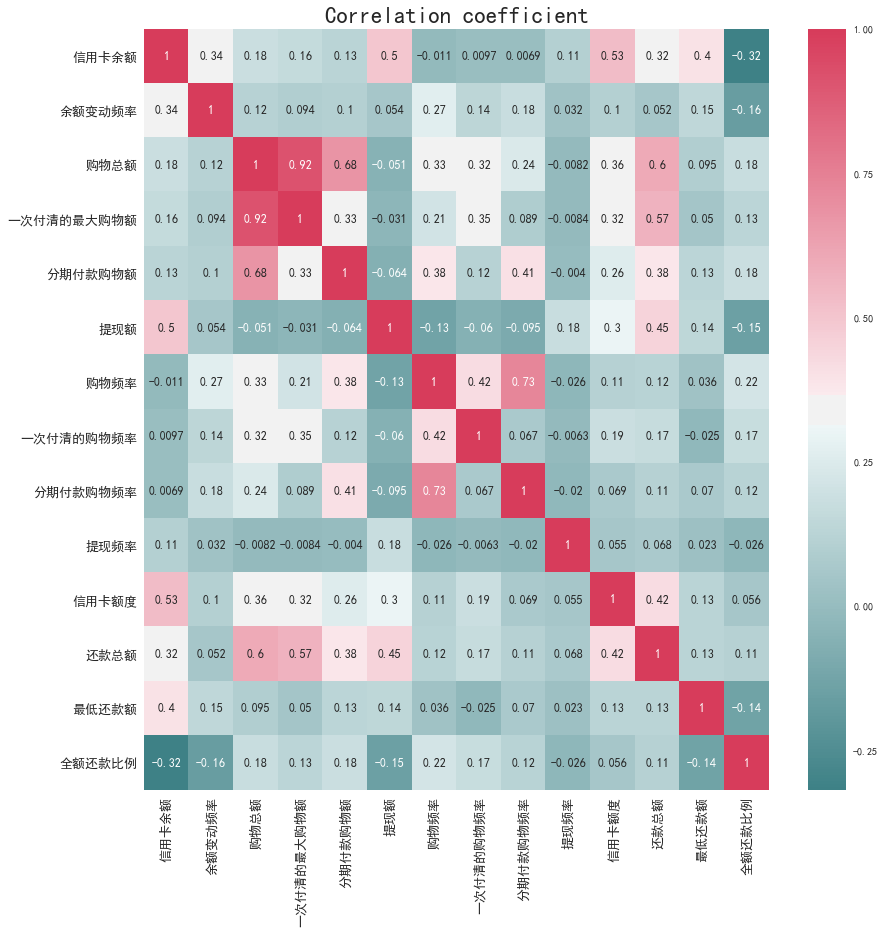

In [37]:
plt.rcParams['font.sans-serif'] =['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(14,14))
ax = sns.heatmap(df.corr(),annot=True,cmap=sns.diverging_palette(200, 5, as_cmap=True))
bottom, top = ax.get_ylim() #解决热力图边缘只有一半的问题
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Correlation coefficient',y=1.02,size=23)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)

In [38]:
df['购物比率'] = df.购物总额/df.信用卡额度
df['分期付款购物比率'] = df.分期付款购物额/df.信用卡额度
df['提现比率'] = df.提现额/df.信用卡额度
#删除不使用的字段
df.drop(['信用卡余额','分期付款购物频率','一次付清的最大购物额','分期付款购物额','购物总额','提现额','最低还款额','还款总额'],axis=1,inplace=True) 
#数据备份
usedf = df.copy()

In [39]:
usedf

,余额变动频率,购物频率,一次付清的购物频率,提现频率,信用卡额度,全额还款比例,购物比率,分期付款购物比率,提现比率
0,0,0,0,0,1000.0,0.000000,0.095400,0.09540,0.000000
1,0,0,0,0,7000.0,0.222222,0.000000,0.00000,0.920421
2,1,1,1,0,7500.0,0.000000,0.103089,0.00000,0.000000
3,0,0,0,0,7500.0,0.000000,0.199867,0.00000,0.027438
4,1,0,0,0,1200.0,0.000000,0.013333,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...
8945,1,1,0,0,1000.0,0.500000,0.291120,0.29112,0.000000
8946,1,1,0,0,1000.0,0.000000,0.300000,0.30000,0.000000
8947,0,0,0,0,1000.0,0.250000,0.144400,0.14440,0.000000
8948,0,0,0,0,500.0,0.250000,0.000000,0.00000,0.073118


In [40]:
usecols=np.setdiff1d(df.columns,['余额变动频率','购物频率','一次付清的购物频率','提现频率'])
usecols[:-1].reshape((2,-1),order='C') 

array([['信用卡额度', '全额还款比例'],
       ['分期付款购物比率', '提现比率']], dtype=object)

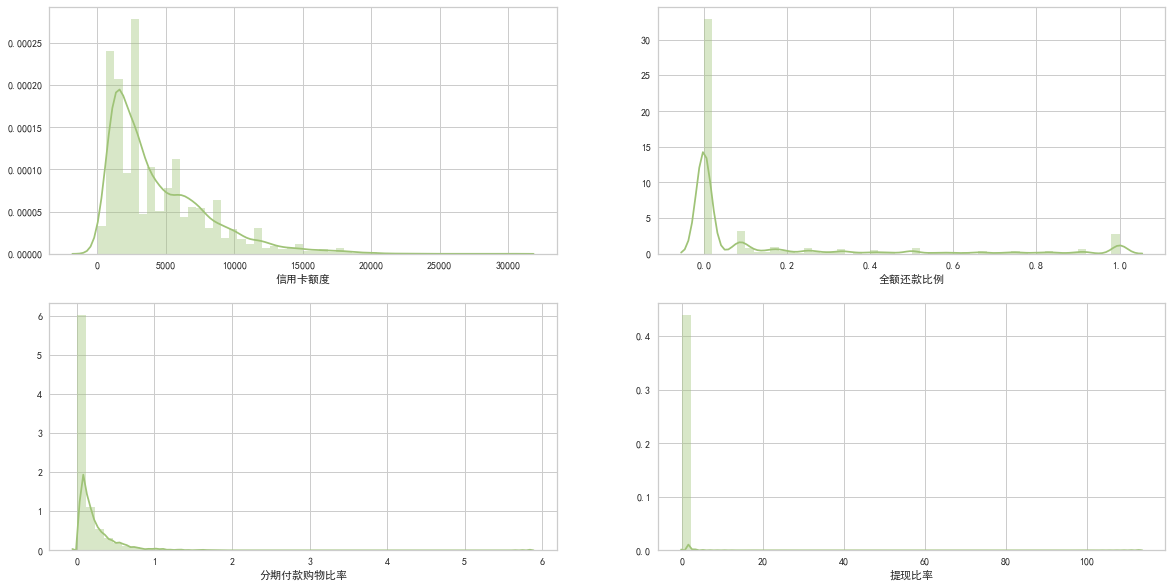

In [41]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
colsreshape=usecols[:-1].reshape((2,-1),order='C') 
fig,axes=plt.subplots(2,2,figsize=(20,10))
for i in np.arange(2):
    for j,index in zip(np.arange(2),colsreshape[i]):
        sns.distplot(usedf[index],ax=axes[i,j],color='g')

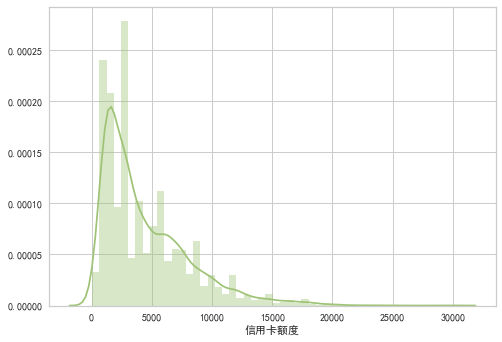

In [42]:
sns.distplot(usedf['信用卡额度'],color='g')

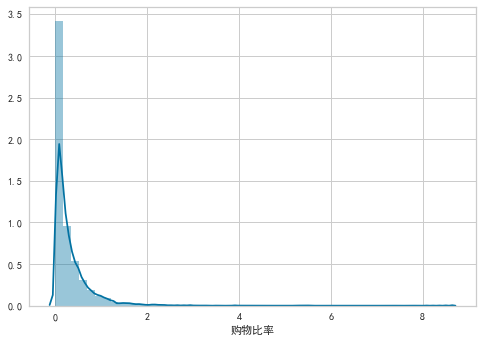

In [43]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
sns.distplot(usedf['购物比率'])

In [44]:
from sklearn import preprocessing as prep 
for i in usecols:
    usedf[i]=np.log1p(df[i])
    usedf[i]=prep.StandardScaler().fit_transform(usedf[i].values.reshape(-1,1))
#对离散型特征直接进行标准化处理 
for j in ['余额变动频率','购物频率','一次付清的购物频率','提现频率']:
    usedf[j]=prep.StandardScaler().fit_transform(usedf[j].values.reshape(-1,1))

In [45]:
df

,余额变动频率,购物频率,一次付清的购物频率,提现频率,信用卡额度,全额还款比例,购物比率,分期付款购物比率,提现比率
0,0,0,0,0,1000.0,0.000000,0.095400,0.09540,0.000000
1,0,0,0,0,7000.0,0.222222,0.000000,0.00000,0.920421
2,1,1,1,0,7500.0,0.000000,0.103089,0.00000,0.000000
3,0,0,0,0,7500.0,0.000000,0.199867,0.00000,0.027438
4,1,0,0,0,1200.0,0.000000,0.013333,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...
8945,1,1,0,0,1000.0,0.500000,0.291120,0.29112,0.000000
8946,1,1,0,0,1000.0,0.000000,0.300000,0.30000,0.000000
8947,0,0,0,0,1000.0,0.250000,0.144400,0.14440,0.000000
8948,0,0,0,0,500.0,0.250000,0.000000,0.00000,0.073118


In [46]:
#定义一个集成聚类过程的类
class Clustering():
    def __init__(self,usedf,df):
        self.usedf=usedf
        self.df=df 
    def doing(self,start=2,end=11):
        from sklearn.cluster import MiniBatchKMeans
        from yellowbrick.cluster import KElbowVisualizer,SilhouetteVisualizer
        from sklearn.metrics import silhouette_score
        plt.rcParams['font.sans-serif']=['SimHei']
        plt.rcParams['axes.unicode_minus'] = False
        fig,axes=plt.subplots(1,2,figsize=(20,5))
        minibatchkmeans=MiniBatchKMeans(init='k-means++',random_state=0)
        #通过肘部法则确定最佳聚类个数
        visualizer=KElbowVisualizer(minibatchkmeans,k=(start,end),ax=axes[0])
        visualizer.fit(self.usedf)   
        self.clusternum=visualizer.elbow_value_
        #使用最佳聚类个数进行聚类
        minibatchkmeans=MiniBatchKMeans(n_clusters=5,init='k-means++',random_state=0)
        preds=minibatchkmeans.fit_predict(self.usedf)
        self.score=silhouette_score(self.usedf,preds,metric='euclidean')
        #评估聚类效果
        estivisualizer=SilhouetteVisualizer(minibatchkmeans,ax=axes[1])
        estivisualizer.fit(self.usedf) 
        visualizer.poof()
        estivisualizer.poof() 
        print('最佳聚类个数为%d，其对应的轮廓系数为%.3f'%(5,self.score))   #5=self.clusternum
        #存储聚类结果
        self.labels=minibatchkmeans.labels_
        self.center=pd.DataFrame(minibatchkmeans.cluster_centers_)
        self.center.columns=self.usedf.columns 
    #给个案打类簇标签
    def labeling(self):
        self.df['所属类簇']=self.labels
    #输出各类簇内的样本比例，并绘制饼图
    def statsratio(self):
        clusternumresults=pd.Series(self.labels).value_counts()
        def func(pct,data):
            num=int(pct/100.*np.sum(data))
            return "{:.2f}%".format(pct,num)
        plt.suptitle('各类簇人数分布',fontsize=13)
        wedges,texts,autotexts=plt.pie(x=clusternumresults.values,autopct=lambda pct:func(pct,clusternumresults),
                                       pctdistance=0.6,textprops={'fontsize':15},rotatelabels='True',colors=["#d5695d", "#5d8ca8", "#65a479","#ffe793","#ffdddd"] ,explode = [0.02 for i in range(len(clusternumresults.index.values))])
        
        plt.legend(wedges,title='所属类簇',labels=['type'+str(i) for i in clusternumresults.index.values],
                   bbox_to_anchor=(0.55,0,0.5,1),fontsize=13)
        for text in autotexts:
            text.set_rotation(15)
        plt.axis('equal')

D:\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
D:\Anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


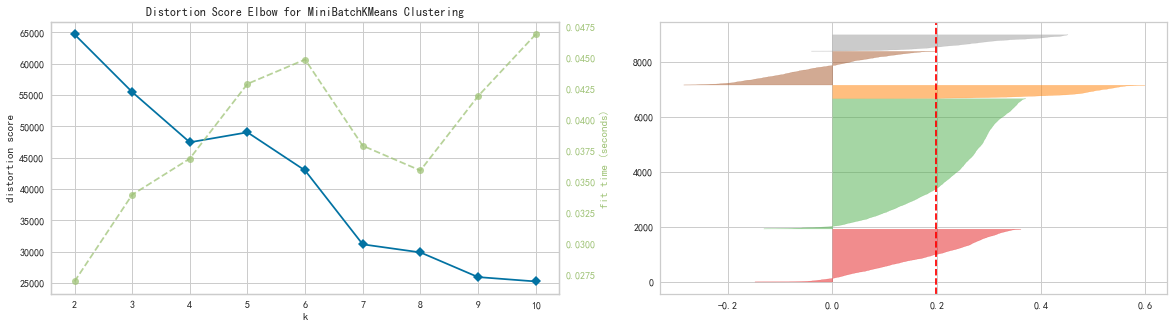

最佳聚类个数为5，其对应的轮廓系数为0.198


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


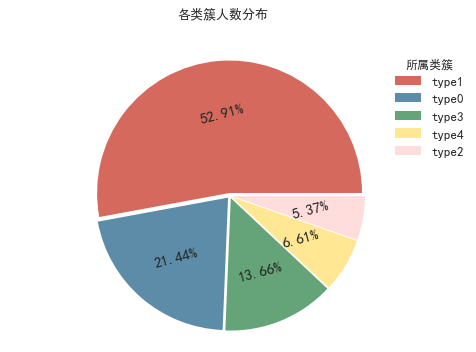

In [47]:
clustering=Clustering(usedf,df) 
clustering.doing()
clustering.labeling()
clustering.statsratio()

In [48]:
clustering.center

,余额变动频率,购物频率,一次付清的购物频率,提现频率,信用卡额度,全额还款比例,购物比率,分期付款购物比率,提现比率
0,-0.149653,-0.507866,-0.238318,-0.025879,-0.307553,-0.362421,-0.524679,-0.467529,1.550829
1,-0.148631,-0.386229,-0.238318,-0.060834,0.176819,-0.128539,-0.304345,-0.328252,-0.396790
2,0.521522,1.763314,4.196078,0.059596,0.794228,0.843305,0.850975,0.004478,-0.479014
3,0.277144,1.072608,-0.238318,-0.060834,-0.353791,0.671340,1.214239,1.444204,-0.466711
4,0.633293,1.697202,-0.238318,0.056180,-1.305365,-0.200291,0.889352,1.560860,-0.557470


In [49]:
center = clustering.center[['余额变动频率','信用卡额度','全额还款比例']]
center

,余额变动频率,信用卡额度,全额还款比例
0,-0.149653,-0.307553,-0.362421
1,-0.148631,0.176819,-0.128539
2,0.521522,0.794228,0.843305
3,0.277144,-0.353791,0.671340
4,0.633293,-1.305365,-0.200291


In [50]:
def drawladar(df):
    from pyecharts.charts import Radar
    names = list(df.columns)
    c_schema = [{"name":names[i],"max":1.2*max(list(df[names[i]])),"min":1.2*min(list(df[names[i]]))} for i in range(len(names))]
    radar = Radar()
    for i in range(len(df.index)):
        radar.add("customertype"+str(i),[list(df.iloc[i])],)
    radar.add_schema(schema=c_schema,shape="polygon")
    radar.set_series_opts(label_opts=opts.LabelOpts(is_show=False))
    radar.set_global_opts(title_opts=opts.TitleOpts(title="radarrrr"))

In [51]:
from pyecharts.charts import Radar
names = list(clustering.center.columns)
c_schema = [{"name":names[i],"max":1.2*max(list(clustering.center[names[i]])),"min":1.2*min(list(clustering.center[names[i]]))} for i in range(len(names))]
radar = Radar()
for i in range(len(clustering.center.index)):
    radar.add("customertype"+str(i),[list(clustering.center.iloc[i])],)
radar.add_schema(schema=c_schema,shape="polygon")
radar.set_series_opts(label_opts=opts.LabelOpts(is_show=False))
radar.set_global_opts(title_opts=opts.TitleOpts(title="radarrrr"))

In [52]:
c_schema

[{'name': '余额变动频率', 'max': 0.7599515275739063, 'min': -0.1795831412403891},
 {'name': '购物频率', 'max': 2.1159762219601683, 'min': -0.6094391554819703},
 {'name': '一次付清的购物频率', 'max': 5.035293317591219, 'min': -0.28598135385067636},
 {'name': '提现频率', 'max': 0.07151547144013538, 'min': -0.07300100392432882},
 {'name': '信用卡额度', 'max': 0.9530731031196227, 'min': -1.566437455443294},
 {'name': '全额还款比例', 'max': 1.0119656340438408, 'min': -0.43490472015997894},
 {'name': '购物比率', 'max': 1.4570866590717102, 'min': -0.6296149627090816},
 {'name': '分期付款购物比率', 'max': 1.8730319975883252, 'min': -0.5610352520143084},
 {'name': '提现比率', 'max': 1.8609945228023141, 'min': -0.668963675319138}]

In [53]:
from pyecharts.charts import Radar
center = clustering.center[['余额变动频率','信用卡额度','全额还款比例']]
names = list(center.columns)
c_schema = [{'name': '余额变动频率', 'max': 0.7599515275739063, 'min': -0.1795831412403891},
           {'name': '信用卡额度', 'max': 0.9530731031196227, 'min': -1.566437455443294},
           {'name': '全额还款比例', 'max': 1.0119656340438408, 'min': -0.43490472015997894}]
radar = Radar()
colorlist = ["#ff3300","#9900cc","#009900","#3333cc","#ff6600","#9933ff"]
for i in range(5):
    radar.add("customertype"+str(i+1),[list(center.iloc[i])],color=colorlist[i])
radar.add_schema(schema=c_schema,shape="polygon")
radar.set_series_opts(label_opts=opts.LabelOpts(is_show=False))
radar.set_global_opts(title_opts=opts.TitleOpts(title="客户特征雷达图"))

In [54]:
radar.render_notebook()

In [55]:
from pyecharts.charts import Radar
center = clustering.center[['一次付清的购物频率','购物频率','提现频率']]
names = list(center.columns)
c_schema = [{'name': '一次付清的购物频率', 'max': 5.035293317591219, 'min': -0.28598135385067636},
           {'name': '购物频率', 'max': 2.1159762219601683, 'min': -0.6094391554819703},
           {'name': '提现频率', 'max': 0.07151547144013538, 'min': -0.07300100392432882}]
radar = Radar()
colorlist = ["#ff3300","#9900cc","#009900","#3333cc","#ff6600","#9933ff"]
for i in range(5):
    radar.add("customertype"+str(i+1),[list(center.iloc[i])],color=colorlist[i])
radar.add_schema(schema=c_schema,shape="polygon")
radar.set_series_opts(label_opts=opts.LabelOpts(is_show=False))
radar.set_global_opts(title_opts=opts.TitleOpts(title="客户特征雷达图"))

In [56]:
radar.render_notebook()

In [57]:
from pyecharts.charts import Radar
center = clustering.center[['购物比率','分期付款购物比率','提现比率']]
names = list(center.columns)
c_schema = [{'name': '购物比率', 'max': 1.4570866590717102, 'min': -0.6296149627090816},
           {'name': '分期付款购物比率', 'max': 1.8730319975883247, 'min': -0.5610352520143084},
           {'name': '提现比率', 'max': 1.8609945228023141, 'min': -0.668963675319138}]
radar = Radar()
colorlist = ["#ff3300","#9900cc","#009900","#3333cc","#ff6600","#9933ff"]
for i in range(5):
    radar.add("customertype"+str(i+1),[list(center.iloc[i])],color=colorlist[i])
radar.add_schema(schema=c_schema,shape="polygon")
radar.set_series_opts(label_opts=opts.LabelOpts(is_show=False))
radar.set_global_opts(title_opts=opts.TitleOpts(title="客户特征雷达图"))


In [58]:
radar.render_notebook()